## Fit autocovariance

In [3]:
import os
from glob import glob
import threading

import numpy as np
import dask.dataframe as dd
from dask import delayed
import pandas as pd
import xarray as xr
import scipy.optimize
#import mitequinox.sigp as sp

%matplotlib inline
from matplotlib import pyplot as plt
#import matplotlib.animation as anima

from inspect import signature
import scipy

In [4]:
from dask.distributed import Client, LocalCluster
cluster = LocalCluster()
#from dask.distributed import Client
#client = Client()  # set up local cluster on your laptop
client = Client(cluster) # with distributed cluster

In [5]:
def get_tidal_frequencies(*args, units="cpd"):
    """
    """
    from pytide import WaveTable
    td = WaveTable()
    if units=="cpd":
        scale=86400/2/np.pi
    elif units=="cph":
        scale=3600/2/np.pi
    else:
        # cps
        scale=1/2/np.pi
    return {c: td.wave(c).freq * scale for c in args}

tidal_omega = get_tidal_frequencies("M2", "K2","S2","N2")
omega_M2,omega_S2,omega_N2,omega_K2, domega, name = tidal_omega["M2"],tidal_omega["S2"],tidal_omega["N2"],tidal_omega["K2"], .2, "semidiurnal"
omega = (omega_M2+omega_S2)/2

In [6]:
omega_sn = (omega_S2-omega_M2)/2

print('Spring-neap cycle : ', 1/(2*omega_sn), 'days')
print('Oscillation after demodulation ( spring-neap cycle /2): ', 1/omega_sn, 'days')

Spring-neap cycle :  14.765294045749723 days
Oscillation after demodulation ( spring-neap cycle /2):  29.530588091499446 days


In [7]:
def y_fit(tau,T,V):
    return V*np.exp(-tau/T)*np.cos(rad*omega_sn*tau)

In [39]:
#root_path = '/home/datawork-lops-osi/equinox/jetn/'
root_path = '/Users/zcaspar/codes/mit4320/'
file_E = root_path +'binned_Ecov_dl2.nc'
file_L = root_path +'binned_Lcov_uu_dl2_flag10.nc'
#path = '/Users/zcaspar/codes/Diagnostics/'+run#local
dsE = xr.open_dataset(file_E)
dsL = xr.open_dataset(file_L)
dsE

<xarray.Dataset>
Dimensions:   (lon_bins: 179, lat_bins: 59, lags: 321)
Coordinates:
  * lon_bins  (lon_bins) float64 -179.0 -177.0 -175.0 ... 173.0 175.0 177.0
  * lat_bins  (lat_bins) float64 -59.0 -57.0 -55.0 -53.0 ... 51.0 53.0 55.0 57.0
  * lags      (lags) float64 0.0 0.125 0.25 0.375 0.5 ... 39.62 39.75 39.88 40.0
Data variables:
    rr        (lags, lon_bins, lat_bins) float64 ...
    ri        (lags, lon_bins, lat_bins) float64 ...
    count     (lon_bins, lat_bins) int64 ...
Attributes:
    binsize:  2.0

In [9]:
dt = 3/24 # time step in days
rad = 2*np.pi
tau = np.arange(0,dsE.lags.max()+dt,dt) #time lag

In [46]:
def fit_function(y,t=None,myfunc=None,first_guess='free',bounds=None,sigma=None):
    """Compute the best fit parameters found using scipy.optimize.curve_fit
        Parameters
        ----------
        y : data to fit
        t : timelag of the correlation function
        myfunc : function we want to fit to our data, y
        p0 : first guess on parameters
        bounds : bounds of the parameters to fit 
        
        Returns
        ----------
        params : parameters for which we obtain the best fit
        error : covariance of params computed in scipy.optimize.curve_fit
        yfit : best fit
        """
    sig = signature(myfunc)
    len_sig = len(sig.parameters.keys())
    try : 
        if first_guess=='lag' and sigma is None:
            _p0 = np.full(len_sig-1,1)
            _p0[-1] = y[0]
            params,cov = scipy.optimize.curve_fit(myfunc,t,y,p0=_p0,bounds=bounds,maxfev=1000)
    #    try:
        if sigma is not None:
            if first_guess=='lag':
                _p0 = np.full(len_sig-1,1)
                _p0[-1] = y[0]
                params,cov = scipy.optimize.curve_fit(myfunc,t,y,p0=_p0,bounds=bounds,maxfev=1000,
                                                  sigma=sigma,absolute_sigma=True)
            else:
                params,cov = scipy.optimize.curve_fit(myfunc,t,y,bounds=bounds,maxfev=1000,
                                                  sigma=sigma,absolute_sigma=True)
        else:
            params,cov = scipy.optimize.curve_fit(myfunc,t,y,bounds=bounds,maxfev=1000)
        yfit = myfunc(t,*[p for p in params])
        error=np.sqrt(np.diag(cov))
    except:
        params,error = np.full(len_sig-1,np.nan),np.full(len_sig-1,np.nan)
        yfit = np.full_like(t,np.nan)
#        out = xr.Dataset({'params':(['lat_bins','lon_bins','param'],np.expand_dims(params, axis=0)),
#                      'fitted':(['lat_bins','lon_bins','lags'],np.expand_dims(yfit,axis=0)),
#                     'error' : (['lat_bins','lon_bins','param'],np.expand_dims(cov,axis=0))},
 #                    coords={'lat_bins':np.array([y.lat_bins.values]),'lon_bins':np.array([y.lon_bins.values])
 #                            ,'param':[V for V in sig.parameters.keys()][1:],
 #                            'lags':y.lags.values})
    return params,error,yfit
def wrapper(ds,v,myfunc,t,bounds,p0='free',sigma=None):
    sig = signature(myfunc)
    params_name = [V for V in sig.parameters.keys()][1:]
    kwargs={'t':t,'myfunc':myfunc,'first_guess':p0,'bounds':bounds}
    if sigma is not None:
        kwargs.update({'sigma':sigma})
        
    print('Parameters to estimate:',params_name)
    params,error,yfit = xr.apply_ufunc(fit_function,ds[v],input_core_dims=[['lags']],
                                   output_core_dims=[['param'],['param'],['lags']],
                                   vectorize=True,kwargs=kwargs)
    params = params.rename('parameters').assign_coords({'param':params_name})
    error = error.rename('error').assign_coords({'param':params_name})
    ds_out = xr.merge([params,error,yfit])
#    ds_out = ds_out.where(ds_out[v].isel(lags=0)>1e-18)
    return ds_out

In [40]:
dsE = dsE.where(dsE.rr.isel(lags=0)>0)

In [18]:
dsE_out = wrapper(dsE,'rr',y_fit,tau,bounds=([-np.inf,-np.inf],[np.inf,np.inf]))

Parameters to estimate: ['T', 'V']


In [41]:
dsL = dsL.isel(lags=slice(0,None,3))

In [20]:
dsL_out = wrapper(dsL,'rr',y_fit,tau,bounds=([-np.inf,-np.inf],[np.inf,np.inf]))

Parameters to estimate: ['T', 'V']


In [21]:
import cartopy.crs as ccrs
def plot_maps(ds,colmap='RdBu_r',vlim=(-0.01,0.01),axes=111):
    crs = ccrs.Robinson()
    #fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(axes,projection=crs)
    ds.plot(vmax=vlim[1],vmin=vlim[0],y='lat_bins',ax=ax,
            transform=ccrs.PlateCarree(),cmap=colmap,label=False,
           cbar_kwargs={'fraction':0.02})
    ax.gridlines(draw_labels=True)
    return fig,ax

In [14]:
dsE = dsE.where(dsE.rr.isel(lags=0)>0)
dsL = dsL.where(dsL.rr.isel(lags=0)>0)

In [22]:
dsE['rr_norm'] = dsE.rr/dsE.rr.isel(lags=0)
dsL['rr_norm'] = dsL.rr/dsL.rr.isel(lags=0)

In [23]:
dsE_out['rr_norm'] = dsE_out.rr/dsE_out.rr.isel(lags=0)
dsL_out['rr_norm'] = dsL_out.rr/dsL_out.rr.isel(lags=0)

Text(0.5, 1.0, 'Estimated Eulerian variance over autocovariance at time lag 0 (1°x1° bins)')

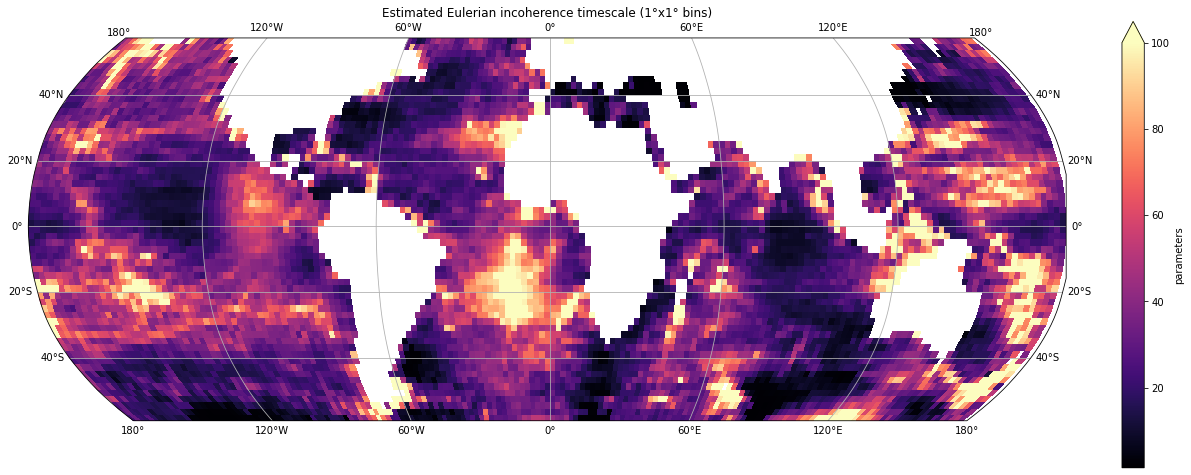

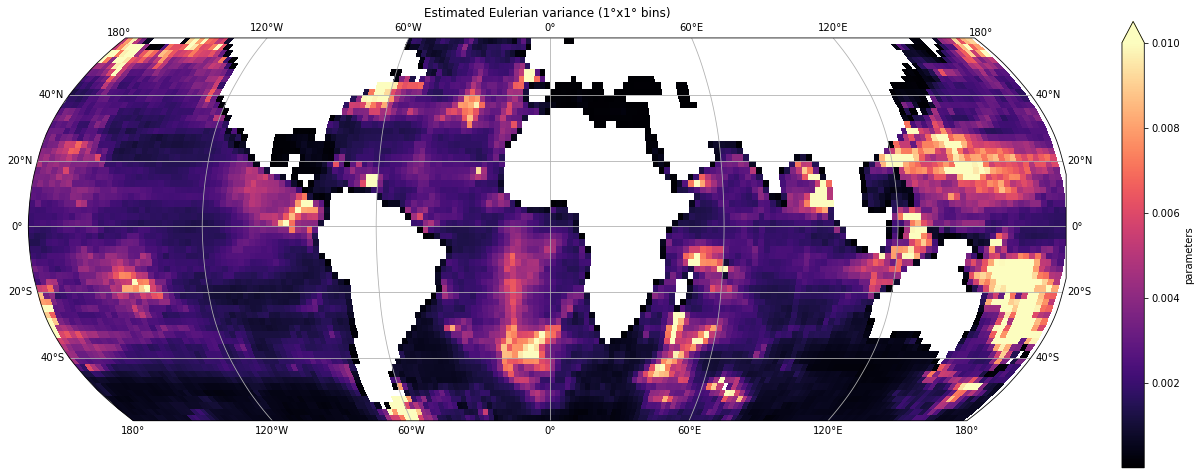

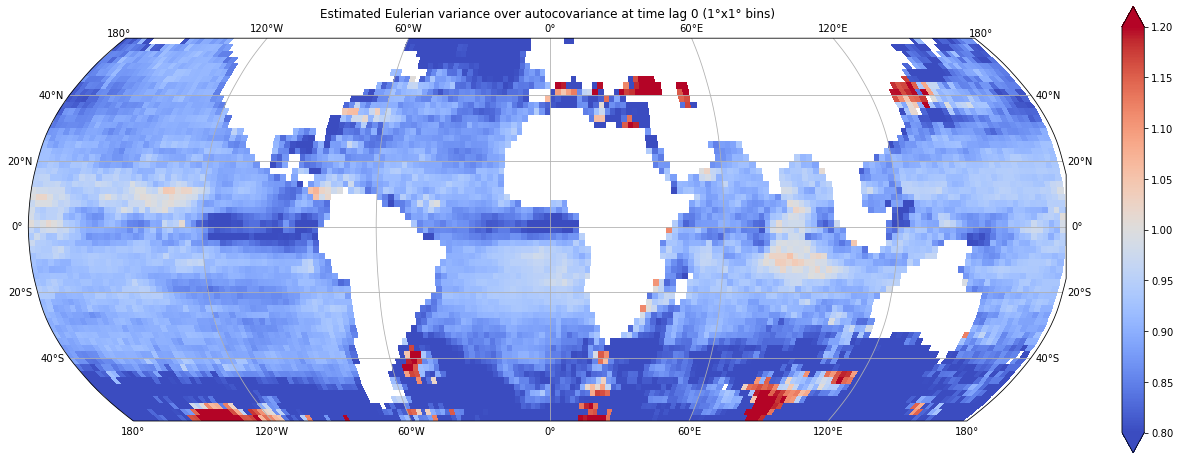

In [25]:
figsize = (20,20)
fig = plt.figure(figsize=figsize)
fig,ax = plot_maps(dsE_out.sel(param = 'T').parameters,colmap='magma',vlim=(None,100))
ax.set_title('Estimated Eulerian incoherence timescale (1°x1° bins)')

figsize = (20,20)
fig = plt.figure(figsize=figsize)
fig,ax = plot_maps(dsE_out.sel(param = 'V').parameters,colmap='magma',vlim=(None,0.01))
ax.set_title('Estimated Eulerian variance (1°x1° bins)')

figsize = (20,20)
fig = plt.figure(figsize=figsize)
fig,ax = plot_maps((dsE_out.sel(param = 'V').parameters/dsE.rr.isel(lags=0))
                   ,colmap='coolwarm',vlim=(0.8,1.2))
ax.set_title('Estimated Eulerian variance over autocovariance at time lag 0 (1°x1° bins)')

Text(0.5, 1.0, 'Estimated Lagrangian variance over autocovariance at time lag 0 (1°x1° bins)')

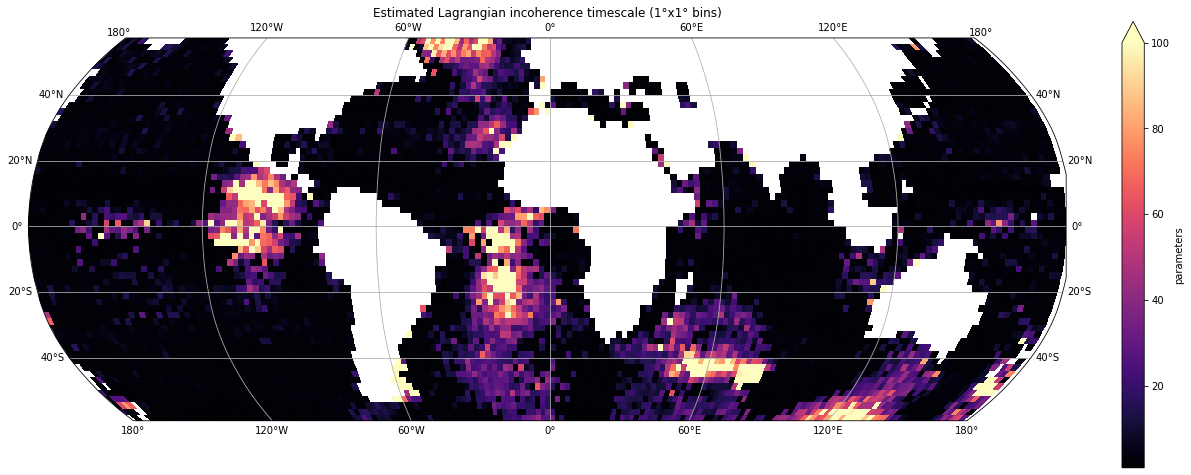

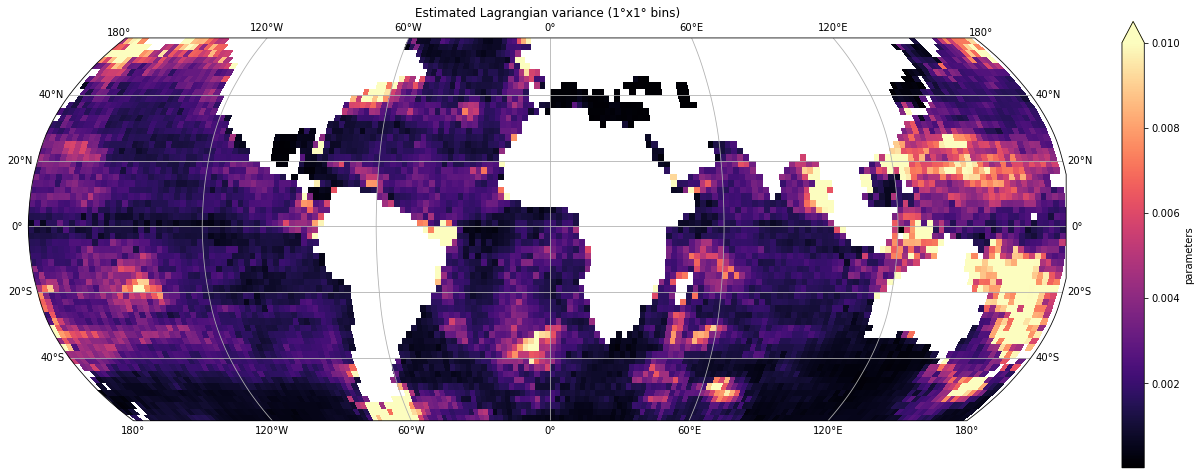

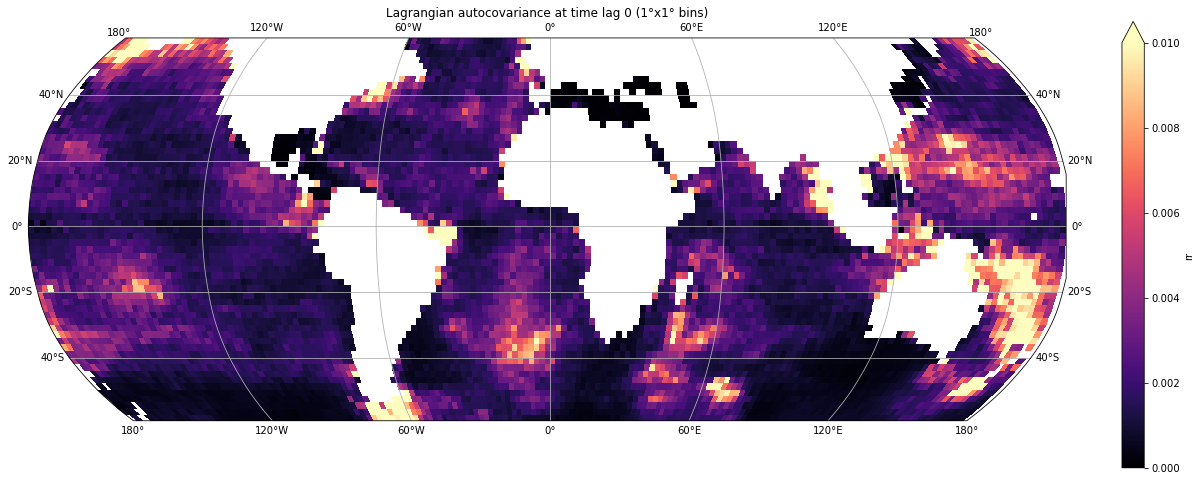

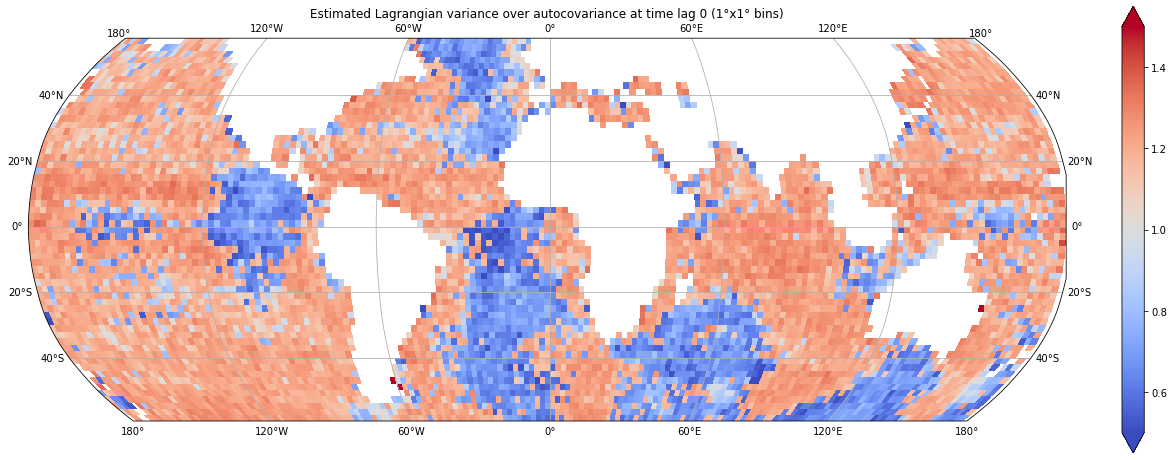

In [26]:
figsize = (20,20)
fig = plt.figure(figsize=figsize)
fig,ax = plot_maps(dsL_out.sel(param = 'T').parameters,colmap='magma',vlim=(None,100))
ax.set_title('Estimated Lagrangian incoherence timescale (1°x1° bins)')

figsize = (20,20)
fig = plt.figure(figsize=figsize)
fig,ax = plot_maps(dsL_out.sel(param = 'V').parameters,colmap='magma',vlim=(None,0.01))
ax.set_title('Estimated Lagrangian variance (1°x1° bins)')

figsize = (20,20)
fig = plt.figure(figsize=figsize)
fig,ax = plot_maps(dsL.rr.isel(lags=0)
                   ,colmap='magma',vlim=(0,0.01))
ax.set_title('Lagrangian autocovariance at time lag 0 (1°x1° bins)')

figsize = (20,20)
fig = plt.figure(figsize=figsize)
fig,ax = plot_maps((dsL_out.sel(param = 'V').parameters/dsL.rr.isel(lags=0))
                   ,colmap='coolwarm',vlim=(0.5,1.5))
ax.set_title('Estimated Lagrangian variance over autocovariance at time lag 0 (1°x1° bins)')

#### Autocovariance form and corresponding best fit

In [27]:
# Area of interest
bbox_cal = [-125,35] #california
bbox_med = [4,40] # mediterranean sea
bbox_nwa = [115,-15] # North-west Australia
bbox_nea = [160,-15] # North-west Australia
bbox_swa = [120,-40] # South-west Australia
#bbox_neh = [-160, 35] # North-east Hawaii
bbox_eq = [-125,0] #equator
bbox_atl = [-10,-20]

#for bbox in [bbox_cal,bbox_nwa,bbox_nea,bbox_swa,bbox_med,bbox_eq,bbox_atl]:
#    ax.scatter(bbox[0],bbox[1],c='g',edgecolor='k',transform=ccrs.PlateCarree())

Text(0.5, 0.98, 'Lagrangian autocorrelation')

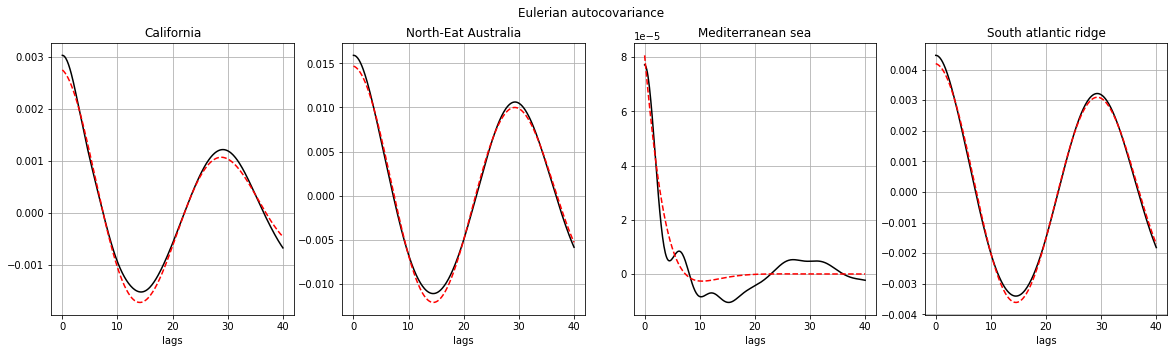

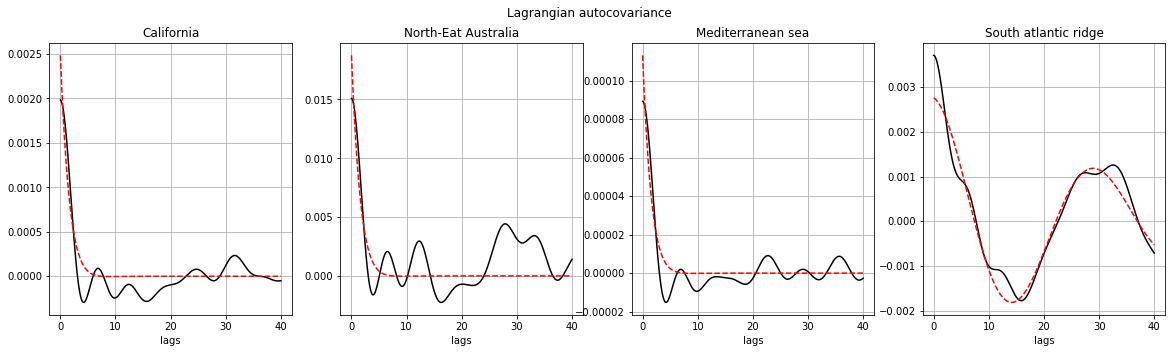

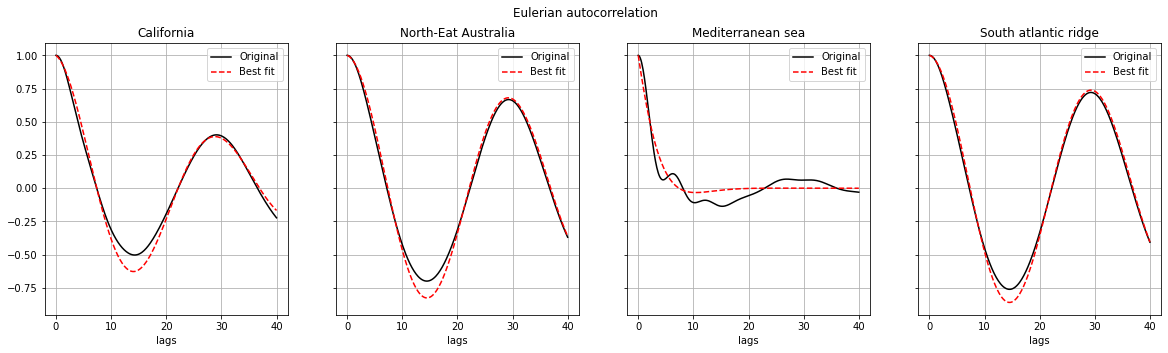

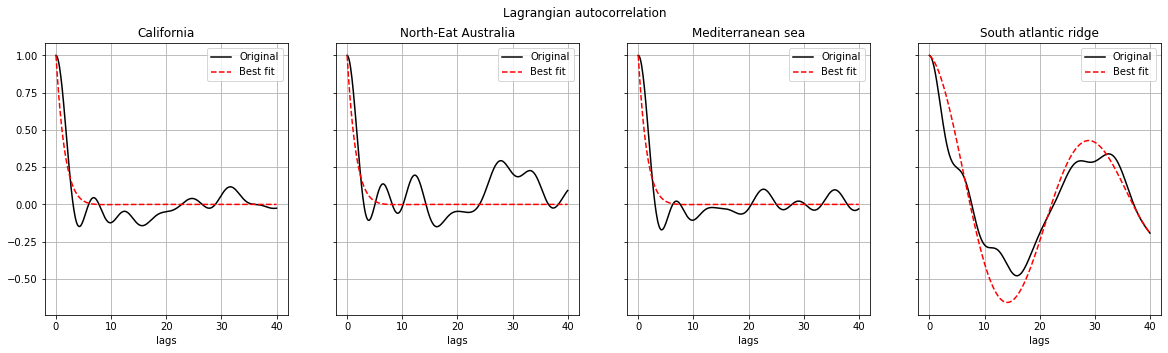

In [28]:
boxes = {'California':bbox_cal,'North-Eat Australia':bbox_nea,'Mediterranean sea':bbox_med,
         'South atlantic ridge':bbox_atl}
fig,axes = plt.subplots(1,len(boxes),figsize=(5*len(boxes),5))
for ax, bbox in zip(axes,boxes):
    dsE.rr.sel(lat_bins=boxes[bbox][1],lon_bins=boxes[bbox][0],method='nearest'
                  ).plot(ax=ax,c='k',label='Original')
    dsE_out.rr.sel(lat_bins=boxes[bbox][1],lon_bins=boxes[bbox][0],method='nearest'
                  ).plot(ax=ax,c='r',linestyle='--',label='Best fit')
    ax.set_ylabel('');ax.grid();ax.set_title(bbox);
fig.suptitle('Eulerian autocovariance')
    
fig,axes = plt.subplots(1,len(boxes),figsize=(5*len(boxes),5))
for ax, bbox in zip(axes,boxes):
    dsL.rr.sel(lat_bins=boxes[bbox][1],lon_bins=boxes[bbox][0],method='nearest'
                  ).plot(ax=ax,c='k',label='Original')
    dsL_out.rr.sel(lat_bins=boxes[bbox][1],lon_bins=boxes[bbox][0],method='nearest'
                  ).plot(ax=ax,c='r',linestyle='--',label='Best fit')
    ax.set_ylabel('');ax.grid();ax.set_title(bbox);
fig.suptitle('Lagrangian autocovariance')

fig,axes = plt.subplots(1,len(boxes),figsize=(5*len(boxes),5),sharey=True)
for ax, bbox in zip(axes,boxes):
    dsE.rr_norm.sel(lat_bins=boxes[bbox][1],lon_bins=boxes[bbox][0],method='nearest'
                  ).plot(ax=ax,c='k',label='Original')
    dsE_out.rr_norm.sel(lat_bins=boxes[bbox][1],lon_bins=boxes[bbox][0],method='nearest'
                  ).plot(ax=ax,c='r',linestyle='--',label='Best fit')
    ax.set_ylabel('');ax.grid();ax.set_title(bbox);ax.legend()
fig.suptitle('Eulerian autocorrelation')

fig,axes = plt.subplots(1,len(boxes),figsize=(5*len(boxes),5),sharey=True)
for ax, bbox in zip(axes,boxes):
    dsL.rr_norm.sel(lat_bins=boxes[bbox][1],lon_bins=boxes[bbox][0],method='nearest'
                  ).plot(ax=ax,c='k',label='Original')
    dsL_out.rr_norm.sel(lat_bins=boxes[bbox][1],lon_bins=boxes[bbox][0],method='nearest'
                  ).plot(ax=ax,c='r',linestyle='--',label='Best fit')
    ax.set_ylabel('');ax.grid();ax.set_title(bbox);ax.legend()
fig.suptitle('Lagrangian autocorrelation')

### Testing more complex fit

#### Using the autocovariance at $\tau=0$ as first guess for $\tilde V$

In [29]:
dsE_out = wrapper(dsE,'rr',y_fit,tau,p0='lag',bounds=([-np.inf,-np.inf],[np.inf,np.inf]))

Parameters to estimate: ['T', 'V']


In [30]:
dsL_out = wrapper(dsL,'rr',y_fit,tau,p0='lag',bounds=([-np.inf,-np.inf],[np.inf,np.inf]))

Parameters to estimate: ['T', 'V']


Text(0.5, 1.0, 'Estimated Eulerian variance over autocovariance at time lag 0 (1°x1° bins)')

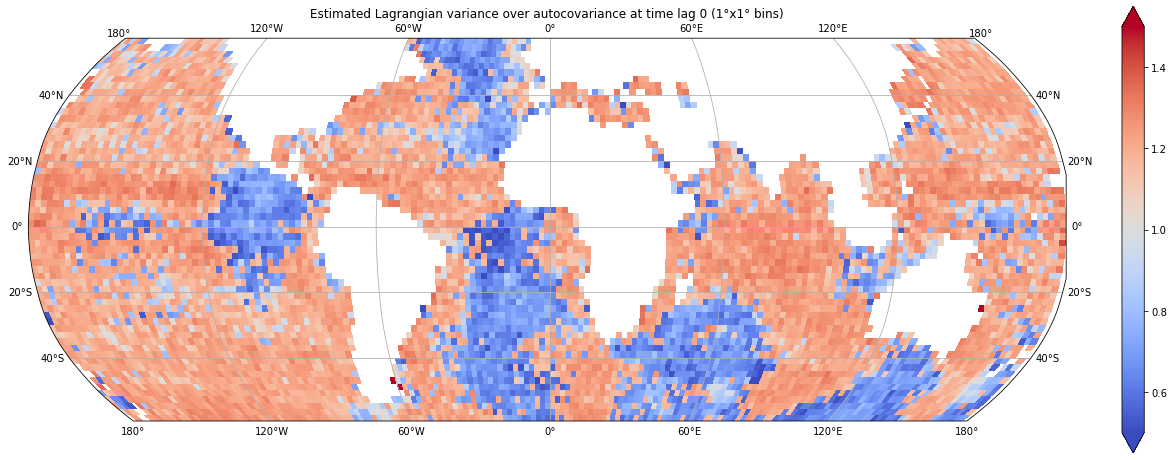

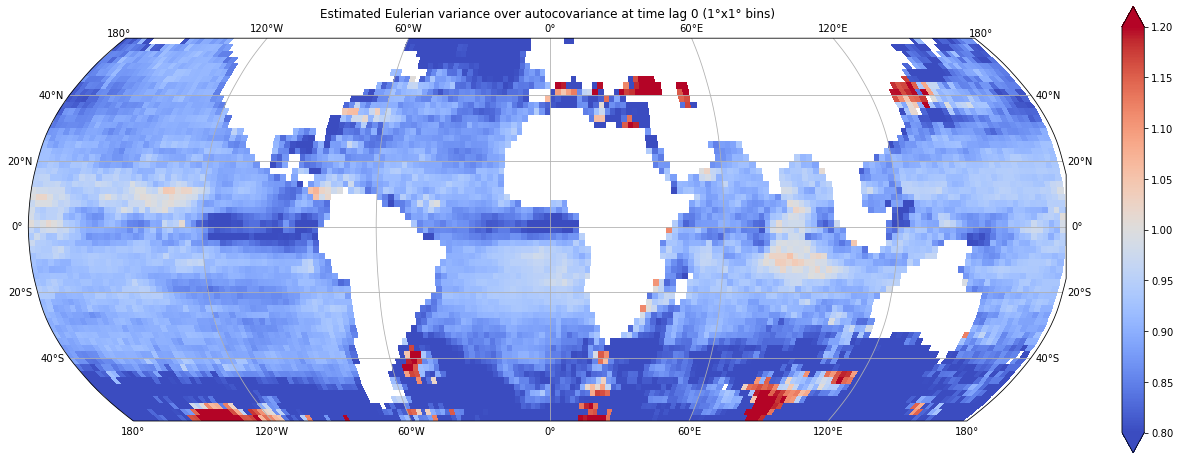

In [31]:
figsize = (20,20)
fig = plt.figure(figsize=figsize)
fig,ax = plot_maps((dsL_out.sel(param = 'V').parameters/dsL.rr.isel(lags=0))
                   ,colmap='coolwarm',vlim=(0.5,1.5))
ax.set_title('Estimated Lagrangian variance over autocovariance at time lag 0 (1°x1° bins)')

figsize = (20,20)
fig = plt.figure(figsize=figsize)
fig,ax = plot_maps((dsE_out.sel(param = 'V').parameters/dsE.rr.isel(lags=0))
                   ,colmap='coolwarm',vlim=(0.8,1.2))
ax.set_title('Estimated Eulerian variance over autocovariance at time lag 0 (1°x1° bins)')

Text(0.5, 0.98, 'Lagrangian autocovariance')

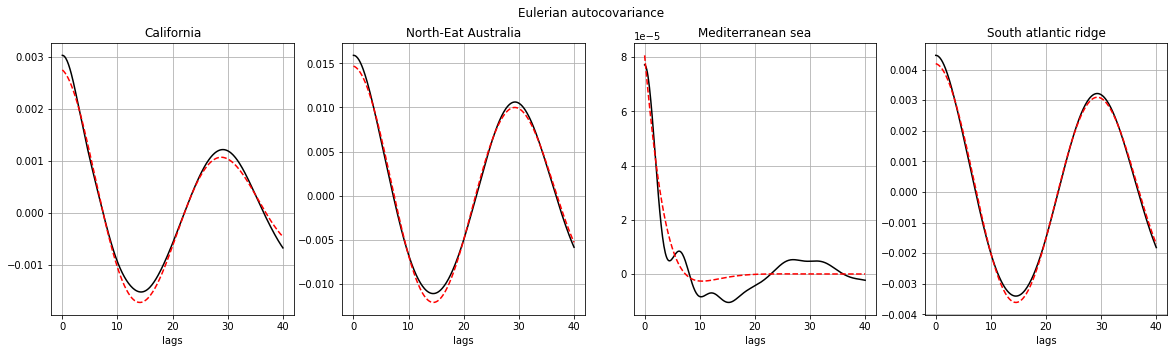

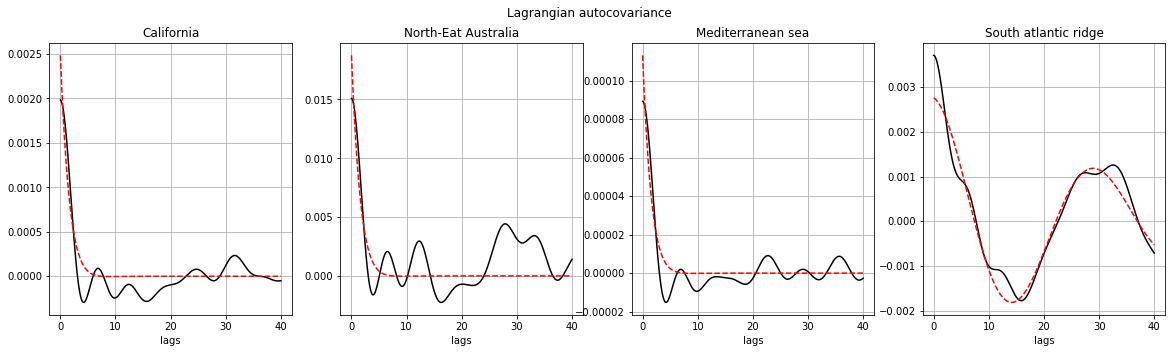

In [32]:
fig,axes = plt.subplots(1,len(boxes),figsize=(5*len(boxes),5))
for ax, bbox in zip(axes,boxes):
    dsE.rr.sel(lat_bins=boxes[bbox][1],lon_bins=boxes[bbox][0],method='nearest'
                  ).plot(ax=ax,c='k',label='Original')
    dsE_out.rr.sel(lat_bins=boxes[bbox][1],lon_bins=boxes[bbox][0],method='nearest'
                  ).plot(ax=ax,c='r',linestyle='--',label='Best fit')
    ax.set_ylabel('');ax.grid();ax.set_title(bbox);
fig.suptitle('Eulerian autocovariance')
    
fig,axes = plt.subplots(1,len(boxes),figsize=(5*len(boxes),5))
for ax, bbox in zip(axes,boxes):
    dsL.rr.sel(lat_bins=boxes[bbox][1],lon_bins=boxes[bbox][0],method='nearest'
                  ).plot(ax=ax,c='k',label='Original')
    dsL_out.rr.sel(lat_bins=boxes[bbox][1],lon_bins=boxes[bbox][0],method='nearest'
                  ).plot(ax=ax,c='r',linestyle='--',label='Best fit')
    ax.set_ylabel('');ax.grid();ax.set_title(bbox);
fig.suptitle('Lagrangian autocovariance')

#### With bounds

In [33]:
dsE_out = wrapper(dsE,'rr',y_fit,tau,p0='lag',bounds=([1,0],[2000,10]))

Parameters to estimate: ['T', 'V']


In [34]:
dsL_out = wrapper(dsL,'rr',y_fit,tau,p0='lag',bounds=([1,0],[2000,10]))

Parameters to estimate: ['T', 'V']


Text(0.5, 1.0, 'Estimated Lagrangian incoherence timescale (1°x1° bins)')

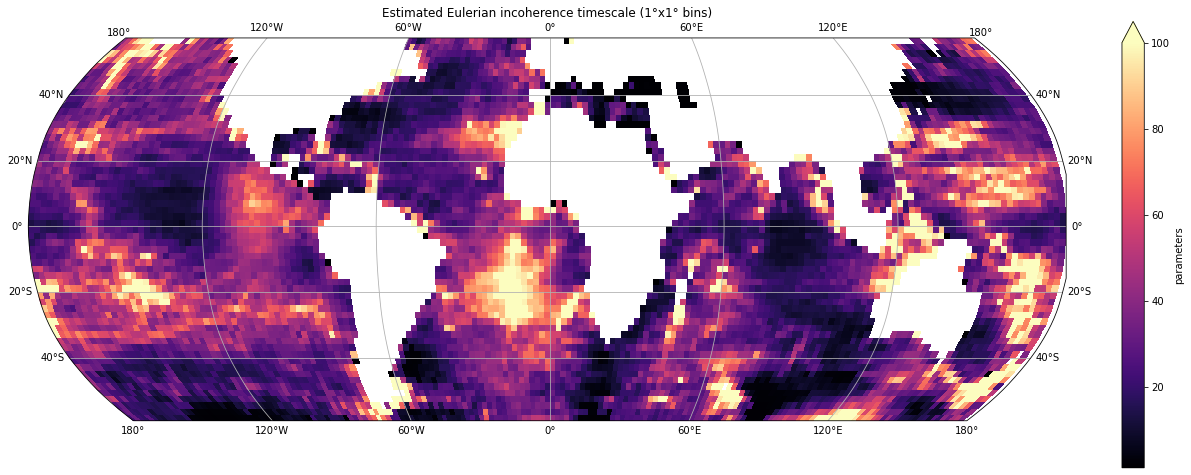

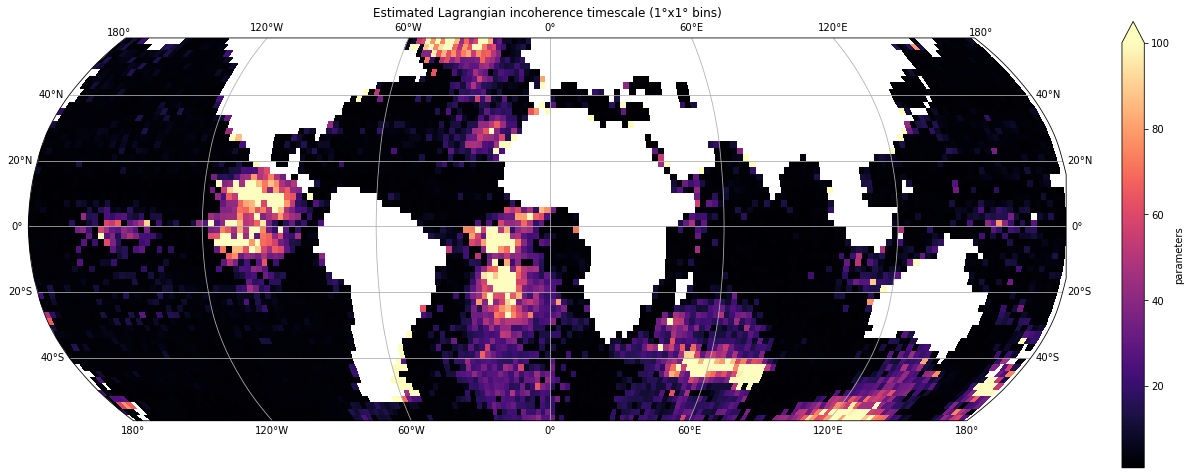

In [35]:
figsize = (20,20)
fig = plt.figure(figsize=figsize)
fig,ax = plot_maps(dsE_out.sel(param = 'T').parameters,colmap='magma',vlim=(None,100))
ax.set_title('Estimated Eulerian incoherence timescale (1°x1° bins)')

figsize = (20,20)
fig = plt.figure(figsize=figsize)
fig,ax = plot_maps(dsL_out.sel(param = 'T').parameters,colmap='magma',vlim=(None,100))
ax.set_title('Estimated Lagrangian incoherence timescale (1°x1° bins)')

Text(0.5, 1.0, 'Estimated Eulerian variance over autocovariance at time lag 0 (1°x1° bins)')

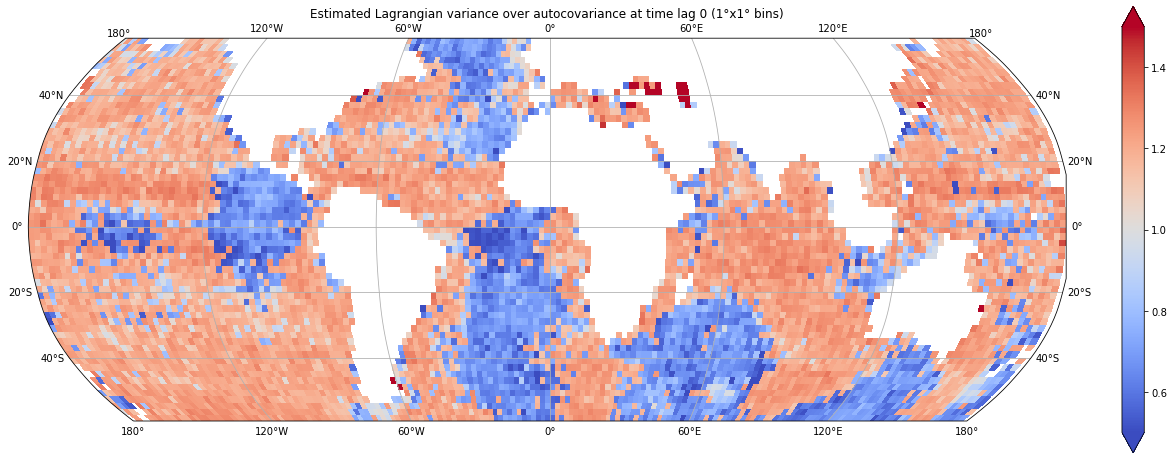

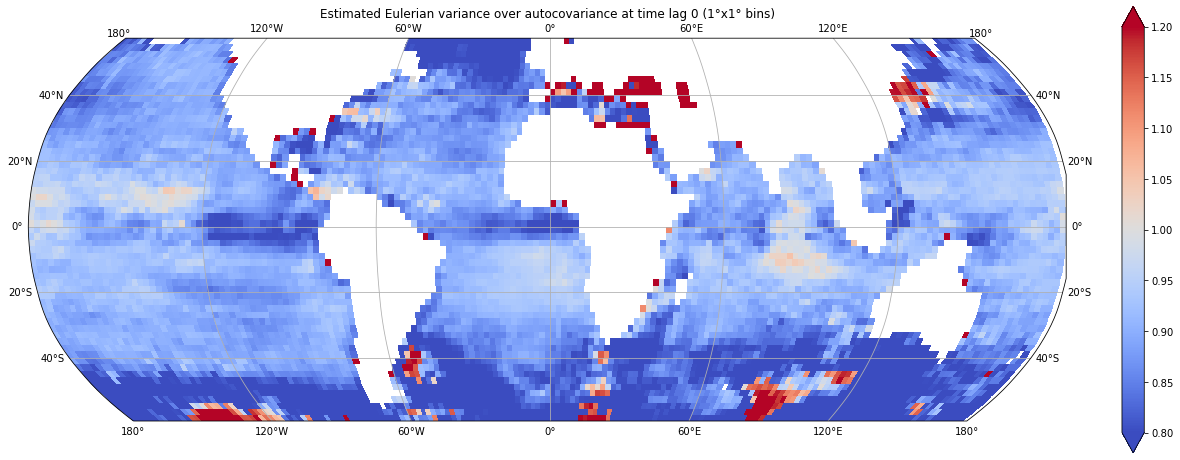

In [36]:
figsize = (20,20)
fig = plt.figure(figsize=figsize)
fig,ax = plot_maps((dsL_out.sel(param = 'V').parameters/dsL.rr.isel(lags=0))
                   ,colmap='coolwarm',vlim=(0.5,1.5))
ax.set_title('Estimated Lagrangian variance over autocovariance at time lag 0 (1°x1° bins)')

figsize = (20,20)
fig = plt.figure(figsize=figsize)
fig,ax = plot_maps((dsE_out.sel(param = 'V').parameters/dsE.rr.isel(lags=0))
                   ,colmap='coolwarm',vlim=(0.8,1.2))
ax.set_title('Estimated Eulerian variance over autocovariance at time lag 0 (1°x1° bins)')

Text(0.5, 0.98, 'Lagrangian autocovariance')

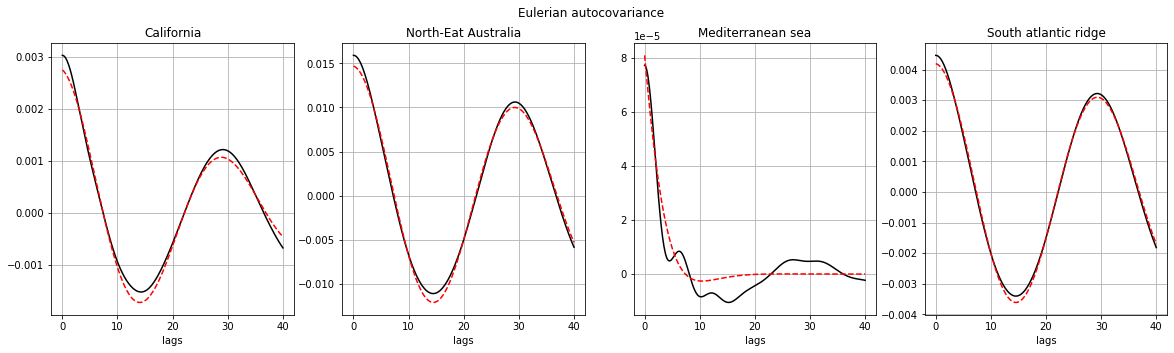

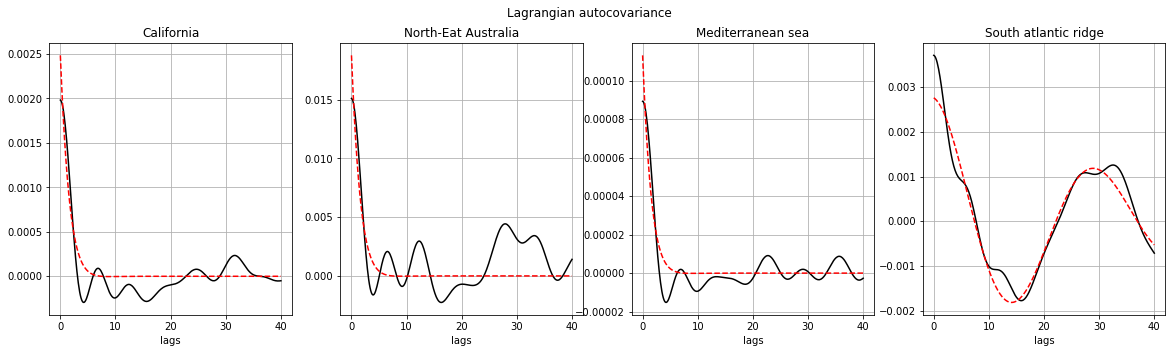

In [37]:
fig,axes = plt.subplots(1,len(boxes),figsize=(5*len(boxes),5))
for ax, bbox in zip(axes,boxes):
    dsE.rr.sel(lat_bins=boxes[bbox][1],lon_bins=boxes[bbox][0],method='nearest'
                  ).plot(ax=ax,c='k',label='Original')
    dsE_out.rr.sel(lat_bins=boxes[bbox][1],lon_bins=boxes[bbox][0],method='nearest'
                  ).plot(ax=ax,c='r',linestyle='--',label='Best fit')
    ax.set_ylabel('');ax.grid();ax.set_title(bbox);
fig.suptitle('Eulerian autocovariance')
    
fig,axes = plt.subplots(1,len(boxes),figsize=(5*len(boxes),5))
for ax, bbox in zip(axes,boxes):
    dsL.rr.sel(lat_bins=boxes[bbox][1],lon_bins=boxes[bbox][0],method='nearest'
                  ).plot(ax=ax,c='k',label='Original')
    dsL_out.rr.sel(lat_bins=boxes[bbox][1],lon_bins=boxes[bbox][0],method='nearest'
                  ).plot(ax=ax,c='r',linestyle='--',label='Best fit')
    ax.set_ylabel('');ax.grid();ax.set_title(bbox);
fig.suptitle('Lagrangian autocovariance')

#### More weight on shorter time lags (20 days) and a lot on $\tau=0$

In [42]:
sigma = np.ones(tau.size)*0.5
sigma[int(20/dt):] = 10
sigma[0] = 0.1

In [47]:
dsE_out = wrapper(dsE,'rr',y_fit,tau,p0='lag',sigma=sigma,bounds=([0,0],[np.inf,np.inf]))

Parameters to estimate: ['T', 'V']


In [48]:
dsL_out = wrapper(dsL,'rr',y_fit,tau,p0='lag',sigma=sigma,bounds=([0,0],[np.inf,np.inf]))

Parameters to estimate: ['T', 'V']


Text(0.5, 1.0, 'Estimated Eulerian variance over autocovariance at time lag 0 (1°x1° bins)')

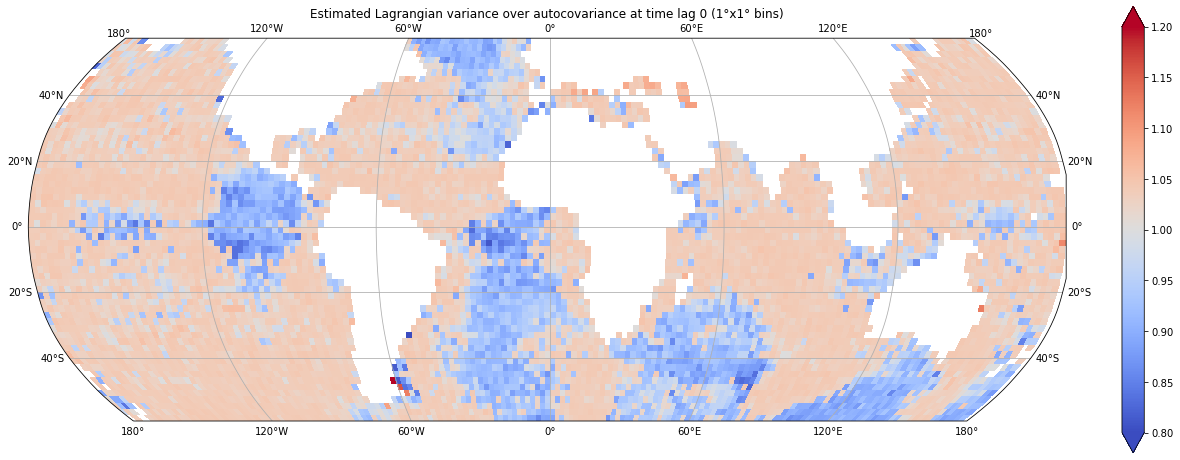

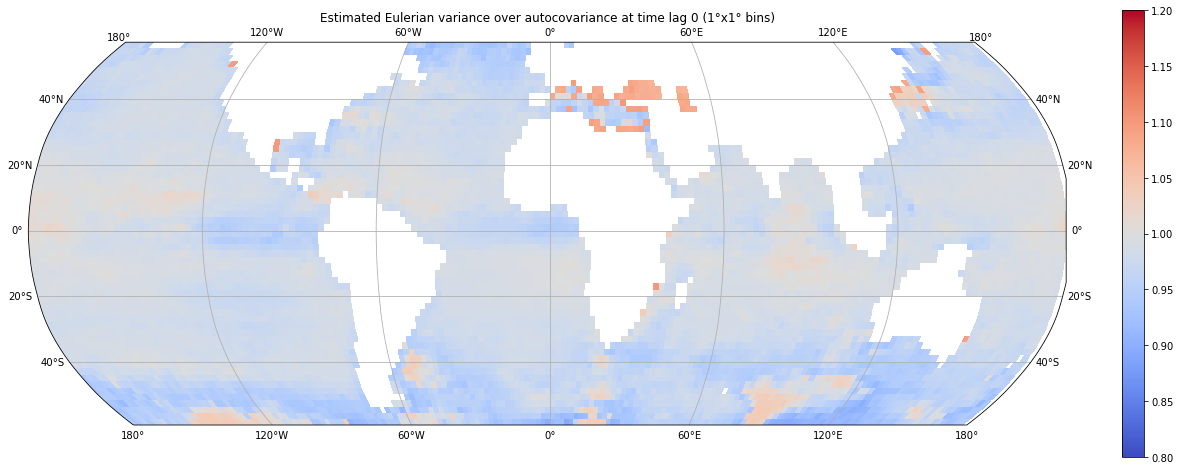

In [49]:
figsize = (20,20)
fig = plt.figure(figsize=figsize)
fig,ax = plot_maps((dsL_out.sel(param = 'V').parameters/dsL.rr.isel(lags=0))
                   ,colmap='coolwarm',vlim=(0.8,1.2))
ax.set_title('Estimated Lagrangian variance over autocovariance at time lag 0 (1°x1° bins)')

figsize = (20,20)
fig = plt.figure(figsize=figsize)
fig,ax = plot_maps((dsE_out.sel(param = 'V').parameters/dsE.rr.isel(lags=0))
                   ,colmap='coolwarm',vlim=(0.8,1.2))
ax.set_title('Estimated Eulerian variance over autocovariance at time lag 0 (1°x1° bins)')

Text(0.5, 0.98, 'Lagrangian autocovariance')

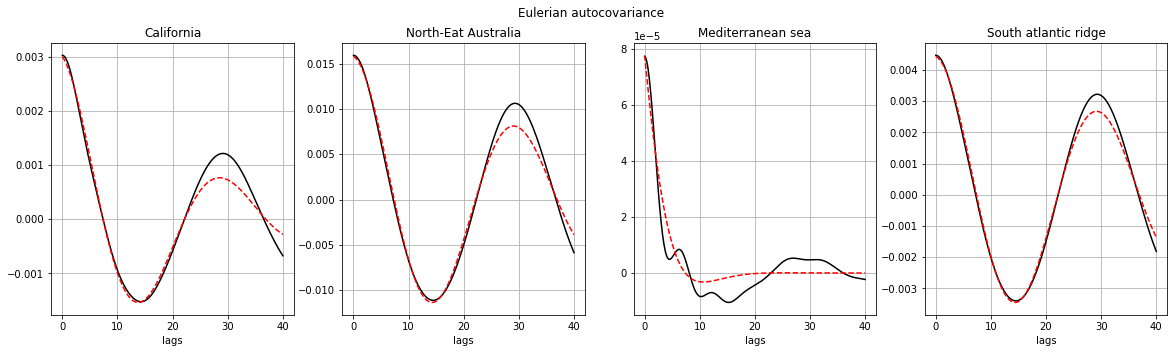

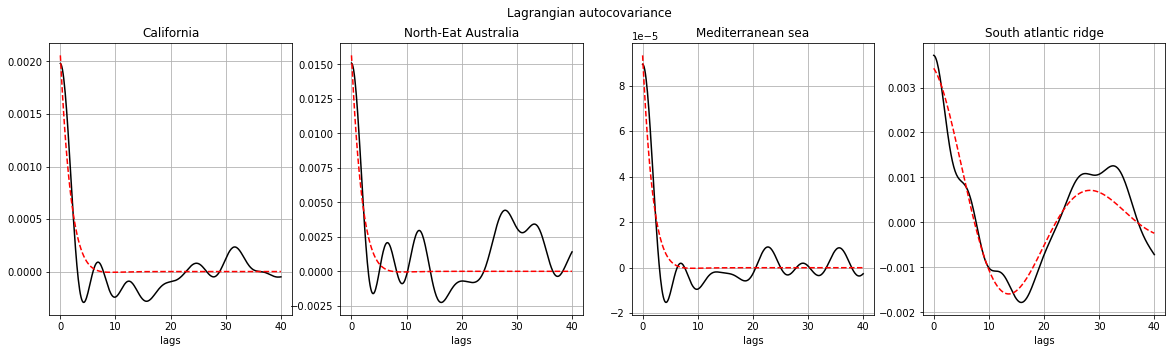

In [50]:
fig,axes = plt.subplots(1,len(boxes),figsize=(5*len(boxes),5))
for ax, bbox in zip(axes,boxes):
    dsE.rr.sel(lat_bins=boxes[bbox][1],lon_bins=boxes[bbox][0],method='nearest'
                  ).plot(ax=ax,c='k',label='Original')
    dsE_out.rr.sel(lat_bins=boxes[bbox][1],lon_bins=boxes[bbox][0],method='nearest'
                  ).plot(ax=ax,c='r',linestyle='--',label='Best fit')
    ax.set_ylabel('');ax.grid();ax.set_title(bbox);
fig.suptitle('Eulerian autocovariance')
    
fig,axes = plt.subplots(1,len(boxes),figsize=(5*len(boxes),5))
for ax, bbox in zip(axes,boxes):
    dsL.rr.sel(lat_bins=boxes[bbox][1],lon_bins=boxes[bbox][0],method='nearest'
                  ).plot(ax=ax,c='k',label='Original')
    dsL_out.rr.sel(lat_bins=boxes[bbox][1],lon_bins=boxes[bbox][0],method='nearest'
                  ).plot(ax=ax,c='r',linestyle='--',label='Best fit')
    ax.set_ylabel('');ax.grid();ax.set_title(bbox);
fig.suptitle('Lagrangian autocovariance')

#### Other models : 
1) Shift

2) Fit to a model with shorter oscillations ($\omega\sim$7days)

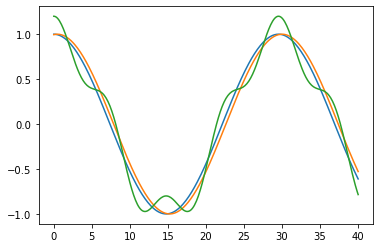

In [51]:
plt.plot(tau,np.cos(omega_sn*rad*tau))
phi=-0.1
plt.plot(tau,np.cos(omega_sn*rad*tau+phi))
#plt.plot(tau,np.cos(4*omega_sn*rad*tau))
plt.plot(tau,np.cos(omega_sn*rad*tau)+0.2*np.cos(4*omega_sn*rad*tau))

In [76]:
def y_shift(tau,phi,T,V):
    return V*np.exp(-tau/T)*np.cos(rad*omega_sn*tau+phi)

def y_osc(tau,Vsmall,omega,T,V):
    return V*np.cos(omega_sn*rad*tau)*np.exp(-tau/T)+Vsmall*np.cos(omega*rad*tau)

def y_osc_v1(tau,Vsmall,T,V):
    return V*np.cos(omega_sn*rad*tau)*np.exp(-tau/T)+Vsmall*np.cos(4*omega_sn*rad*tau)

def y_osc_v2(tau,Vsmall,omega,T,V):
    return (V*np.cos(omega_sn*rad*tau)+Vsmall*np.cos(omega*rad*tau))*np.exp(-tau/T)

def y_osc_v3(tau,Vsmall,Tsmall,omega,T,V):
    return V*np.exp(-tau/T)*np.cos(omega_sn*rad*tau)+Vsmall*np.exp(-tau/Tsmall)*np.cos(omega*rad*tau)



#### Shift

In [53]:
dsE_out = wrapper(dsE,'rr',y_shift,tau,bounds=([-omega_sn*rad,0,0],[omega_sn*rad,np.inf,10]))

Parameters to estimate: ['phi', 'T', 'V']


In [54]:
dsL_out = wrapper(dsL,'rr',y_shift,tau,bounds=([-omega_sn*rad,0,0],[omega_sn*rad,np.inf,10]))

Parameters to estimate: ['phi', 'T', 'V']


Text(0.5, 1.0, 'Estimated Lagrangian incoherence timescale (1°x1° bins)')

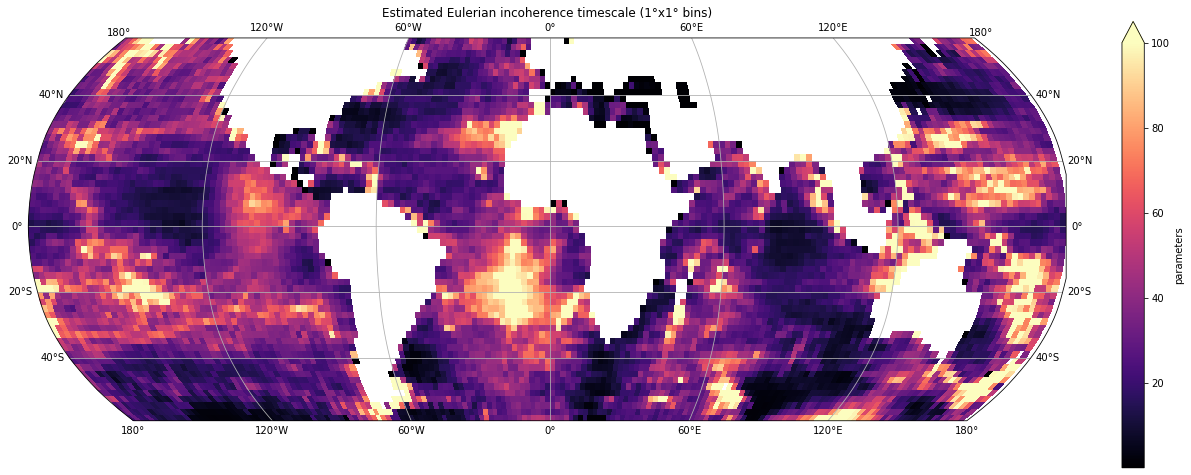

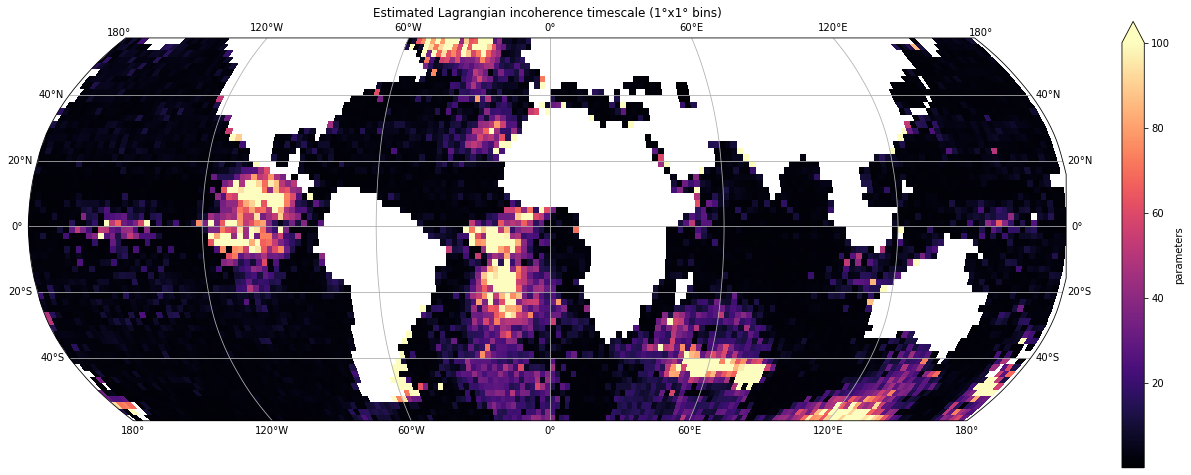

In [56]:
figsize = (20,20)
fig = plt.figure(figsize=figsize)
fig,ax = plot_maps(dsE_out.sel(param = 'T').parameters,colmap='magma',vlim=(None,100))
ax.set_title('Estimated Eulerian incoherence timescale (1°x1° bins)')

figsize = (20,20)
fig = plt.figure(figsize=figsize)
fig,ax = plot_maps(dsL_out.sel(param = 'T').parameters,colmap='magma',vlim=(None,100))
ax.set_title('Estimated Lagrangian incoherence timescale (1°x1° bins)')

Text(0.5, 1.0, 'Estimated Lagrangian shift (1°x1° bins)')

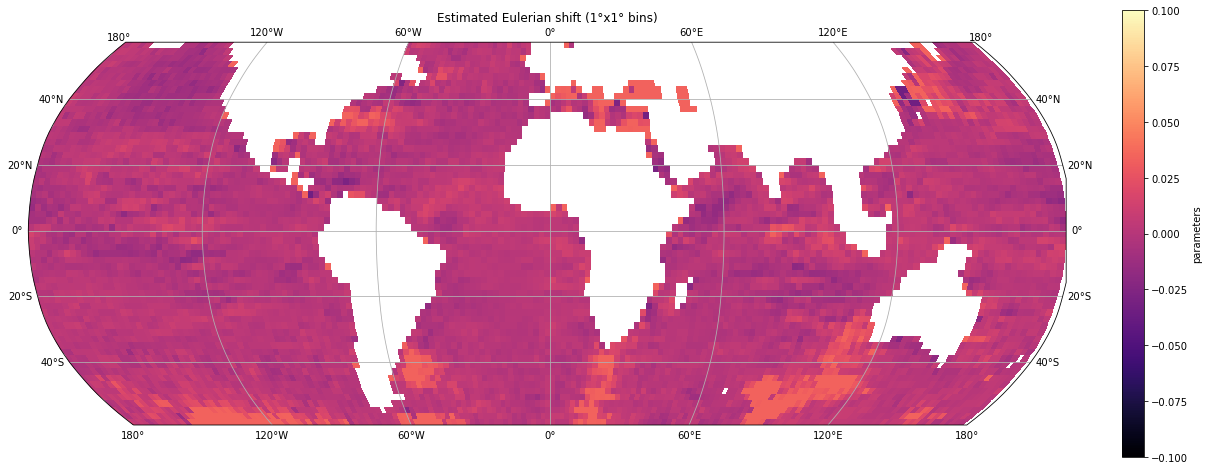

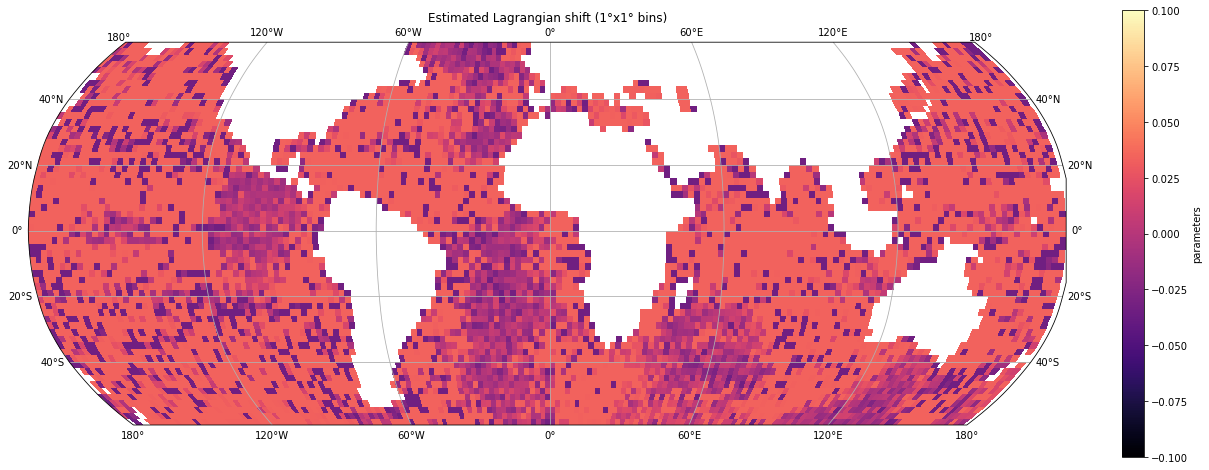

In [57]:
figsize = (20,20)
fig = plt.figure(figsize=figsize)
fig,ax = plot_maps((dsE_out.sel(param = 'phi').parameters/(2*np.pi)),colmap='magma',vlim=(None,0.1))
ax.set_title('Estimated Eulerian shift (1°x1° bins)')

figsize = (20,20)
fig = plt.figure(figsize=figsize)
fig,ax = plot_maps((dsL_out.sel(param = 'phi').parameters/(2*np.pi)),colmap='magma',vlim=(None,0.1))
ax.set_title('Estimated Lagrangian shift (1°x1° bins)')

Text(0.5, 1.0, 'Estimated Lagrangian variance (1°x1° bins)')

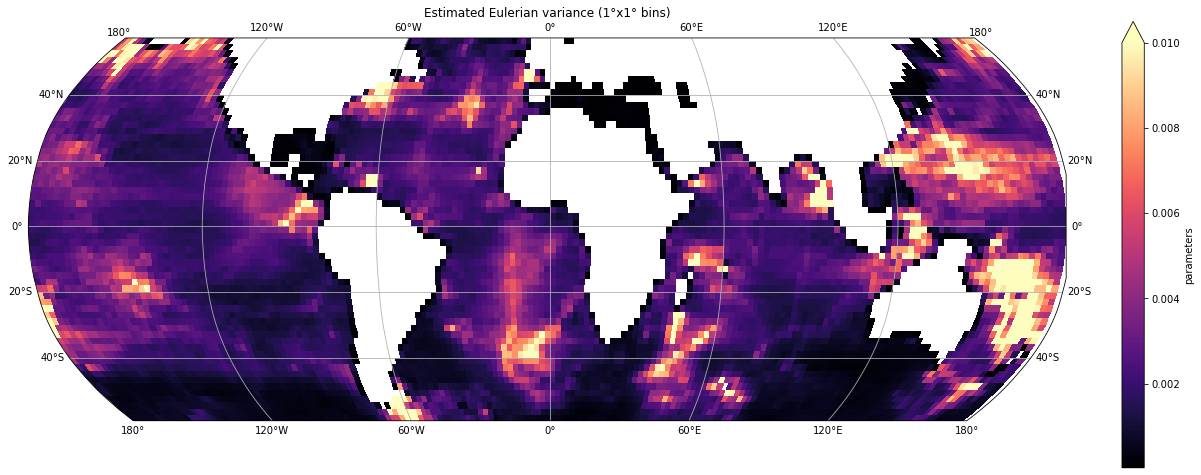

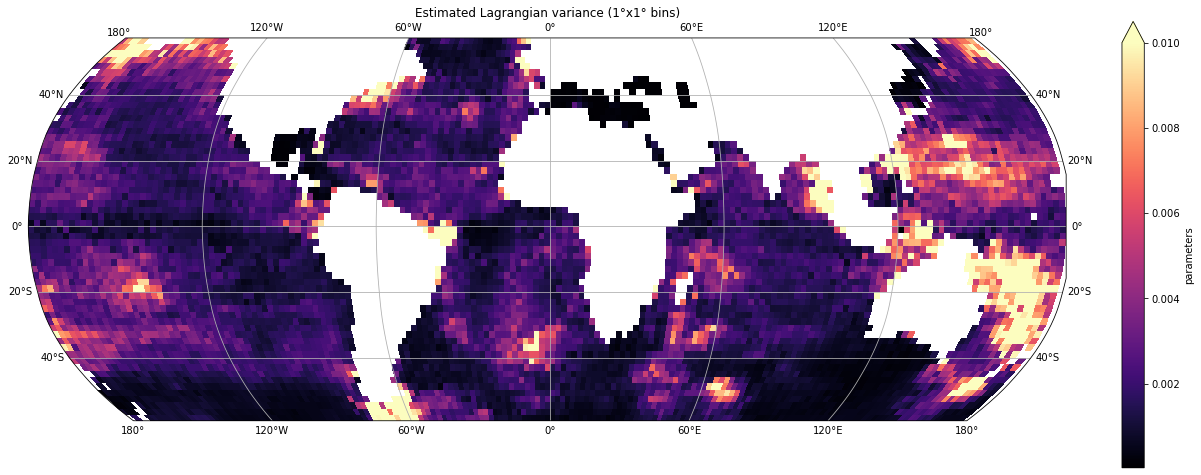

In [58]:
figsize = (20,20)
fig = plt.figure(figsize=figsize)
fig,ax = plot_maps(dsE_out.sel(param = 'V').parameters,colmap='magma',vlim=(None,0.01))
ax.set_title('Estimated Eulerian variance (1°x1° bins)')

figsize = (20,20)
fig = plt.figure(figsize=figsize)
fig,ax = plot_maps(dsL_out.sel(param = 'V').parameters,colmap='magma',vlim=(None,0.01))
ax.set_title('Estimated Lagrangian variance (1°x1° bins)')

Text(0.5, 1.0, 'Estimated Eulerian variance over autocovariance at time lag 0 (1°x1° bins)')

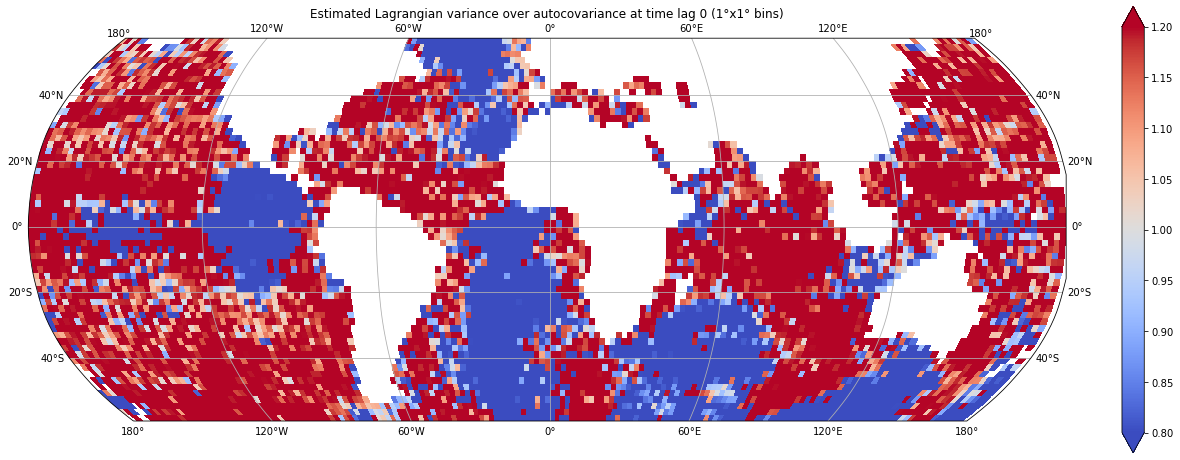

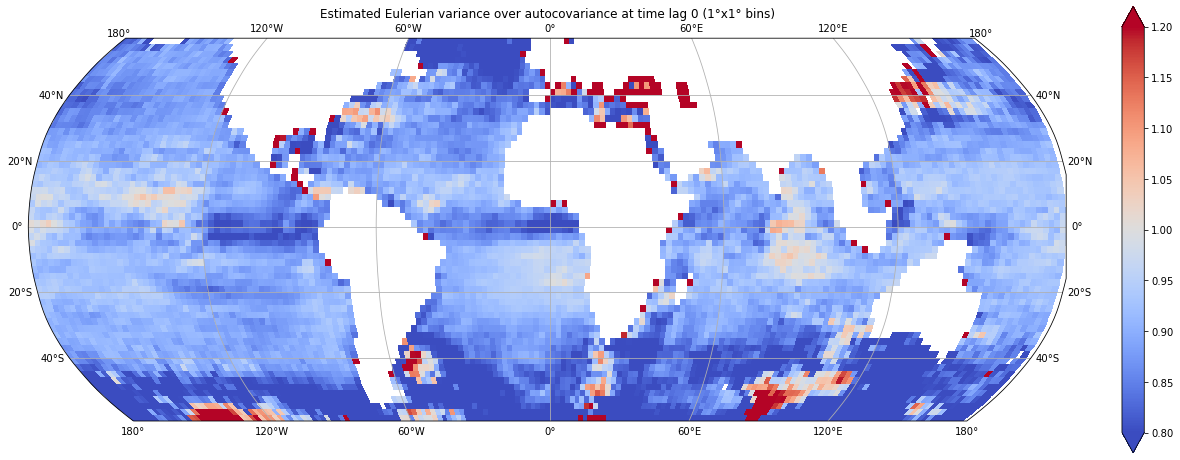

In [59]:
figsize = (20,20)
fig = plt.figure(figsize=figsize)
fig,ax = plot_maps((dsL_out.sel(param = 'V').parameters/dsL.rr.isel(lags=0))
                   ,colmap='coolwarm',vlim=(0.8,1.2))
ax.set_title('Estimated Lagrangian variance over autocovariance at time lag 0 (1°x1° bins)')

figsize = (20,20)
fig = plt.figure(figsize=figsize)
fig,ax = plot_maps((dsE_out.sel(param = 'V').parameters/dsE.rr.isel(lags=0))
                   ,colmap='coolwarm',vlim=(0.8,1.2))
ax.set_title('Estimated Eulerian variance over autocovariance at time lag 0 (1°x1° bins)')

Text(0.5, 0.98, 'Lagrangian autocovariance')

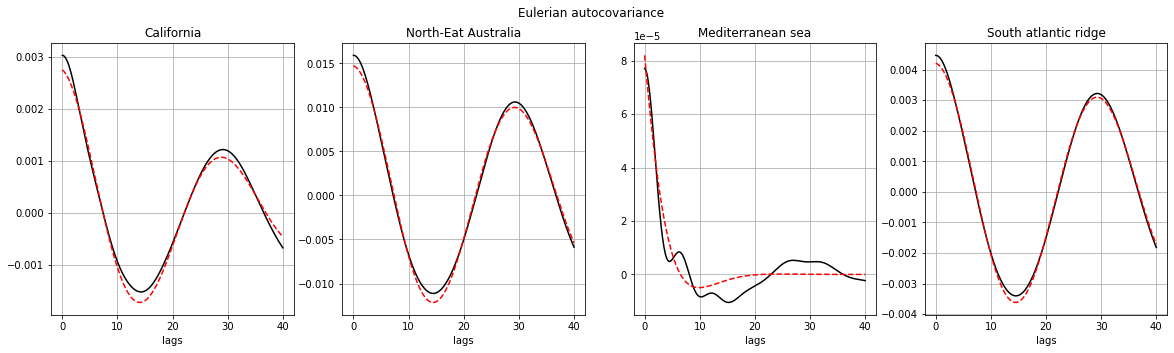

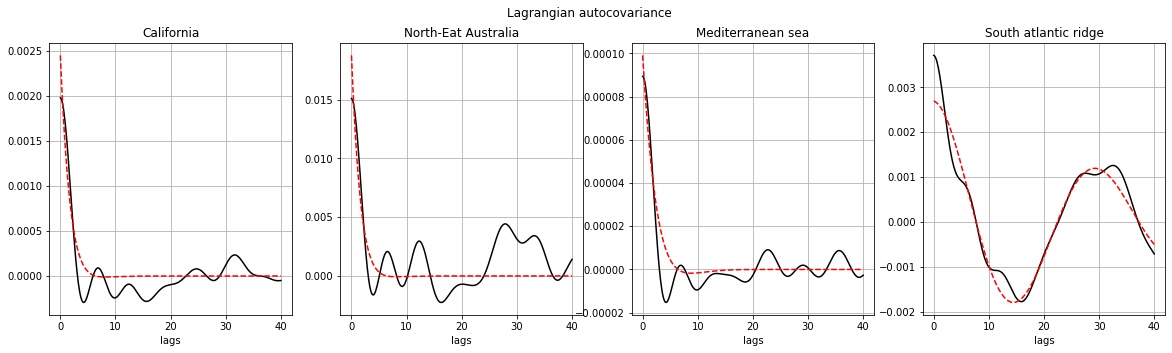

In [60]:
fig,axes = plt.subplots(1,len(boxes),figsize=(5*len(boxes),5))
for ax, bbox in zip(axes,boxes):
    dsE.rr.sel(lat_bins=boxes[bbox][1],lon_bins=boxes[bbox][0],method='nearest'
                  ).plot(ax=ax,c='k',label='Original')
    dsE_out.rr.sel(lat_bins=boxes[bbox][1],lon_bins=boxes[bbox][0],method='nearest'
                  ).plot(ax=ax,c='r',linestyle='--',label='Best fit')
    ax.set_ylabel('');ax.grid();ax.set_title(bbox);
fig.suptitle('Eulerian autocovariance')
    
fig,axes = plt.subplots(1,len(boxes),figsize=(5*len(boxes),5))
for ax, bbox in zip(axes,boxes):
    dsL.rr.sel(lat_bins=boxes[bbox][1],lon_bins=boxes[bbox][0],method='nearest'
                  ).plot(ax=ax,c='k',label='Original')
    dsL_out.rr.sel(lat_bins=boxes[bbox][1],lon_bins=boxes[bbox][0],method='nearest'
                  ).plot(ax=ax,c='r',linestyle='--',label='Best fit')
    ax.set_ylabel('');ax.grid();ax.set_title(bbox);
fig.suptitle('Lagrangian autocovariance')

##### Small oscillations (unknown cause)

In [86]:
dsE_out = wrapper(dsE,'rr',y_osc,tau,bounds=([0,0,0,0],[10,1/10,np.inf,10]))

Parameters to estimate: ['Vsmall', 'omega', 'T', 'V']


In [87]:
dsL_out = wrapper(dsL,'rr',y_osc,tau,bounds=([0,0,0,0],[10,1/10,np.inf,10]))

Parameters to estimate: ['Vsmall', 'omega', 'T', 'V']


In [77]:
dsE_out_v1 = wrapper(dsE,'rr',y_osc_v1,tau,bounds=([0,0,0],[10,np.inf,10]))
dsL_out_v1 = wrapper(dsL,'rr',y_osc_v1,tau,bounds=([0,0,0],[10,np.inf,10]))

Parameters to estimate: ['Vsmall', 'T', 'V']
Parameters to estimate: ['Vsmall', 'T', 'V']


In [88]:
dsE_out_v2 = wrapper(dsE,'rr',y_osc_v2,tau,bounds=([0,0,0,0],[10,1/10,np.inf,10]))
dsL_out_v2 = wrapper(dsL,'rr',y_osc_v2,tau,bounds=([0,0,0,0],[10,1/10,np.inf,10]))

Parameters to estimate: ['Vsmall', 'omega', 'T', 'V']
Parameters to estimate: ['Vsmall', 'omega', 'T', 'V']


In [90]:
dsE_out_v3 = wrapper(dsE,'rr',y_osc_v3,tau,bounds=([0,0,0,0,0],[10,np.inf,1/10,np.inf,10]))
dsL_out_v3 = wrapper(dsL,'rr',y_osc_v3,tau,bounds=([0,0,0,0,0],[10,np.inf,1/10,np.inf,10]))

Parameters to estimate: ['Vsmall', 'Tsmall', 'omega', 'T', 'V']
Parameters to estimate: ['Vsmall', 'Tsmall', 'omega', 'T', 'V']


Text(0.5, 0.98, 'Lagrangian autocovariance')

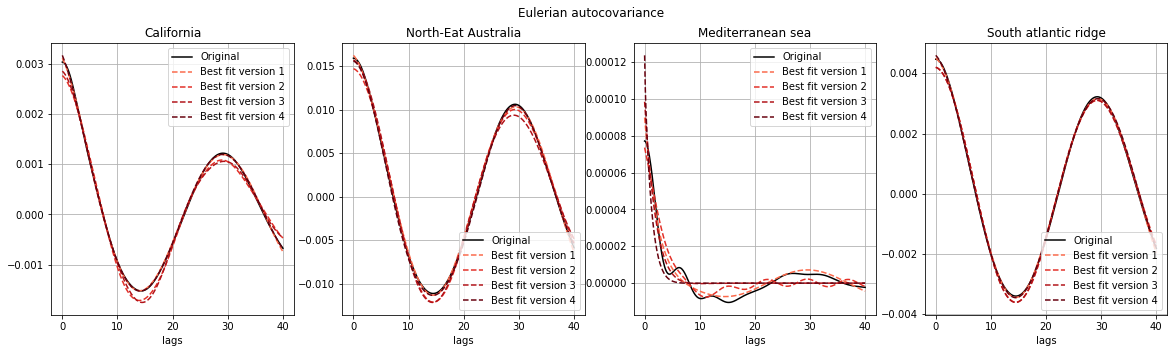

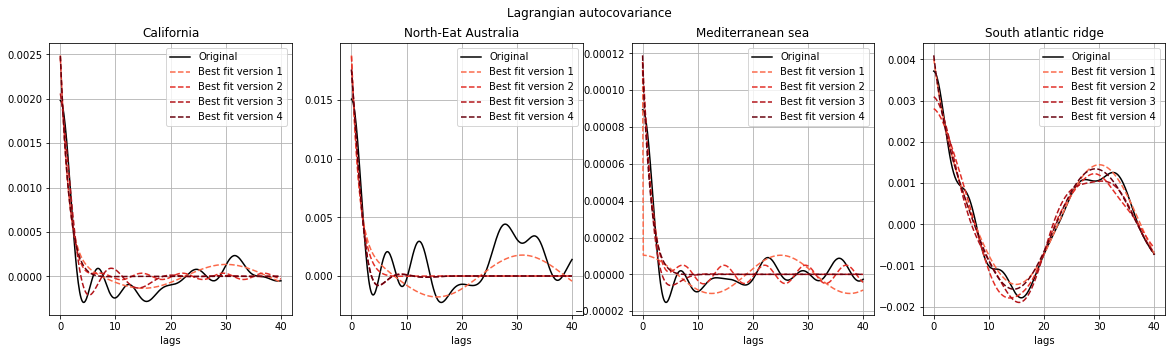

In [91]:
#colors = ['maroon','firebrick','r']
colors = plt.cm.Reds(np.linspace(0.5, 1, 4))
fig,axes = plt.subplots(1,len(boxes),figsize=(5*len(boxes),5))
for ax, bbox in zip(axes,boxes):
    dsE.rr.sel(lat_bins=boxes[bbox][1],lon_bins=boxes[bbox][0],method='nearest'
                  ).plot(ax=ax,c='k',label='Original')
    for i,ds_fit in enumerate([dsE_out,dsE_out_v1,dsE_out_v2,dsE_out_v3]):
        c = colors[i]
        ds_fit.rr.sel(lat_bins=boxes[bbox][1],lon_bins=boxes[bbox][0],method='nearest'
                      ).plot(ax=ax,c=c,linestyle='--',label='Best fit version %s'%str(i+1))
   # dsE_out_v2.rr.sel(lat_bins=boxes[bbox][1],lon_bins=boxes[bbox][0],method='nearest'
   #               ).plot(ax=ax,c='firebrick',linestyle='--',label='Best fit version 2')
    ax.set_ylabel('');ax.grid();ax.set_title(bbox);ax.legend();
fig.suptitle('Eulerian autocovariance')
    
fig,axes = plt.subplots(1,len(boxes),figsize=(5*len(boxes),5))
for ax, bbox in zip(axes,boxes):
    dsL.rr.sel(lat_bins=boxes[bbox][1],lon_bins=boxes[bbox][0],method='nearest'
                  ).plot(ax=ax,c='k',label='Original')
    for i,ds_fit in enumerate([dsL_out,dsL_out_v1,dsL_out_v2,dsL_out_v3]):
        c = colors[i]
        ds_fit.rr.sel(lat_bins=boxes[bbox][1],lon_bins=boxes[bbox][0],method='nearest'
                      ).plot(ax=ax,c=c,linestyle='--',label='Best fit version %s'%str(i+1))
    ax.set_ylabel('');ax.grid();ax.set_title(bbox);ax.legend();
fig.suptitle('Lagrangian autocovariance')

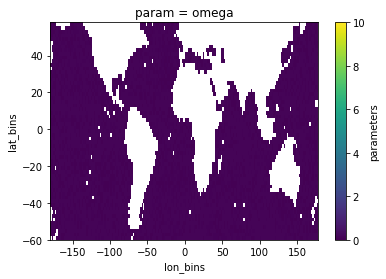

In [93]:
dsL_out_v3.parameters.sel(param='omega').plot(vmax=10)

In [122]:
cluster.close()

# 